In [1]:
import rebound
import numpy as np
import pandas as pd
import dask.dataframe as dd
from celmech import Andoyer
from spock import FeatureClassifier, NbodyRegressor
import os

# In this notebook we generate the SPOCK and Nbody predictions used in the paper

In the dataset section we break down how many configurations fall into different classes following the discussion in Sec. 4 of the paper

# See Orbit Crossing Heading below for simple way to reject orbit-crossing configurations

We regenerate predictions from an old dataframe, but this illustrates a useful pattern with REBOUND: It can be useful to separate the generation of initial conditions from the running of integrations, and to save the initial conditions as SimulationArchives (Rein & Tamayo 2017). This way you store your initial conditions in a binary, machine-independent format, whereas if you ran the same python script to generate initial conditions on different machines, you could get discrepancies in the last binary digit depending on the optimized math libraries used by the machine architecture. It is therefore much better to share SimulationArchives of initial conditions than a script to generate them.

Here we show a sample process of loading SimulationArchives with initial conditions and using those to read the initial conditions to generate SPOCK predictions. Note that the Nbody wrapper in SPOCK by default will overwrite your SimulationArchive with all the additional snapshots when you save archives. That should be fine, but if for some reason it matters to you, you can easily instead append snapshots by doing things manually (see the bottom of this example: https://github.com/dtamayo/spock/blob/master/jupyter_examples/ComparingToNbody.ipynb)

In [2]:
IDs = []
for root, dirs, files in os.walk('K23uniform/'):
    for file in files:
        if 'bin' in file:
            ID = file.split('_')[3]
            IDs.append(int(ID[:-4]))
df = pd.DataFrame(np.sort(np.array(IDs)), columns=['sim'])
df.tail()

,sim
27048,1999380
27049,1999466
27050,1999693
27051,1999943
27052,1999969


# Make a dataframe of all the quantities we want for the paper

In the block after '#celmech' below, we calculate resonant variables using celmech, see:

https://github.com/shadden/celmech/

We have to specify the index of particles in the pair to consider: i1 (inner) and i2 (outer)
Also the j and k indices of a j:j-k MMR. 
Kepler 23 has inner two planets near the 3:2 MMR, outer two near the 7:5 MMR.

In [3]:
def populate(row): # Assumes inner two near 3:2 and outer two near 7:5 like in Kepler23
    safilename = 'K23uniform/K23_logm_sa_{0}.bin'.format(int(row['sim']))
    sa = rebound.SimulationArchive(safilename)
    sim = sa[0]
    P1 = sim.particles[1].P
    
    # celmech
    avars12 = Andoyer.from_Simulation(sim, j=3, k=1, i1=1, i2=2) # need to set j and k for appropriate j:j-k MMR
    row['Mstar'] = sim.particles[0].m
    row['Z12'] = avars12.Z
    avars23 = Andoyer.from_Simulation(sim, j=7, k=2, i1=2, i2=3)
    row['Z23'] = avars23.Z
    
    # Add other quantities of interest
    row['mu1'] = sim.particles[1].m/sim.particles[0].m
    row['mu2'] = sim.particles[2].m/sim.particles[0].m
    row['mu3'] = sim.particles[3].m/sim.particles[0].m
    row['e1'] = sim.particles[1].e
    row['e2'] = sim.particles[2].e
    row['e3'] = sim.particles[3].e
    row['h1'] = sim.particles[1].e*np.sin(sim.particles[1].pomega)
    row['h2'] = sim.particles[2].e*np.sin(sim.particles[2].pomega)
    row['h3'] = sim.particles[3].e*np.sin(sim.particles[3].pomega)
    row['k1'] = sim.particles[1].e*np.cos(sim.particles[1].pomega)
    row['k2'] = sim.particles[2].e*np.cos(sim.particles[2].pomega)
    row['k3'] = sim.particles[3].e*np.cos(sim.particles[3].pomega)
    hcom = (row['mu1']*row['h1'] + row['mu2']*row['h2'] + row['mu3']*row['h3'])/(row['mu1']+row['mu2']+row['mu3'])
    kcom = (row['mu1']*row['k1'] + row['mu2']*row['k2'] + row['mu3']*row['k3'])/(row['mu1']+row['mu2']+row['mu3'])
    row['ecom'] = np.sqrt(hcom**2 + kcom**2)
    return row

Here we use dask for the parallelization

In [4]:
%%time
import dask.dataframe as dd
ddf = dd.from_pandas(df, npartitions=40)
df = ddf.apply(populate, axis=1, meta=pd.DataFrame([populate(df.loc[0])])).compute(scheduler='processes')

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:86: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:86: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:86: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:86: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:86: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspac

CPU times: user 608 ms, sys: 410 ms, total: 1.02 s
Wall time: 44.6 s


In [5]:
df.tail()

,sim,Mstar,Z12,Z23,mu1,mu2,mu3,e1,e2,e3,h1,h2,h3,k1,k2,k3,ecom
27048,1999380.0,0.880613,0.201456,0.102933,2.729311e-06,0.000012,0.000003,0.198727,0.155031,0.014555,-0.099066,-0.101202,0.013028,-0.172274,0.117442,0.006489,0.101288
27049,1999466.0,1.214257,0.028857,0.021840,8.367568e-07,0.000042,0.000007,0.039781,0.010983,0.022669,-0.039776,0.003408,-0.022128,-0.000577,-0.010441,0.004925,0.008076
27050,1999693.0,1.225737,0.075364,0.066737,9.338099e-06,0.000078,0.000004,0.088874,0.108052,0.175515,0.080759,0.007459,-0.001799,-0.037102,-0.107794,-0.175506,0.104393
27051,1999943.0,1.083352,0.130137,0.077125,1.474248e-06,0.000006,0.000018,0.224166,0.236365,0.140135,0.222827,0.185455,0.055326,0.024470,-0.146544,-0.128751,0.156694
27052,1999969.0,1.159434,0.045962,0.052065,3.549245e-06,0.000037,0.000085,0.095140,0.020418,0.050637,-0.057283,-0.017687,0.047178,-0.075962,-0.010202,0.018394,0.026185


# Ejections

While ejections are rare for the non-crossing, close-in low-mass multiplanet systems SPOCK is trained on, they can occur for the highly eccentric orbit-crossing configurations in our prior. We have updated SPOCK now to check for ejections, but we fix things here manually by checking the final SimulationArchives snapshots. This step wouldn't be necessary using latest version of SPOCK

In [6]:
def check_ejection(row):
    safilename = 'K23_logm_sa_{0}.bin'.format(int(row['sim']))
    sa = rebound.SimulationArchive('K23uniform/'+safilename)
    sim = sa[0]
    maxd0 = np.array([p.d for p in sim.particles[1:sim.N_real]]).max()
    P1 = sim.particles[1].P        
    sim = sa[-1]
    d = np.array([p.d for p in sim.particles[1:sim.N_real]])
    row['ejection'] = np.max(d) > 100*maxd0
    row['t_instability'] = sim.t/P1
    return row

In [7]:
%%time
df['ejection'] = False
df['t_instability'] = np.nan
df = df.apply(check_ejection, axis=1)

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:86: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


CPU times: user 15.5 s, sys: 2.13 s, total: 17.6 s
Wall time: 13.1 s


# Label stable systems

In [8]:
df['nbodystable'] = df['t_instability'] > 9.99e8
df.tail()

,sim,Mstar,Z12,Z23,mu1,mu2,mu3,e1,e2,e3,h1,h2,h3,k1,k2,k3,ecom,ejection,t_instability,nbodystable
27048,1999380.0,0.880613,0.201456,0.102933,2.729311e-06,0.000012,0.000003,0.198727,0.155031,0.014555,-0.099066,-0.101202,0.013028,-0.172274,0.117442,0.006489,0.101288,False,5.358731e+04,False
27049,1999466.0,1.214257,0.028857,0.021840,8.367568e-07,0.000042,0.000007,0.039781,0.010983,0.022669,-0.039776,0.003408,-0.022128,-0.000577,-0.010441,0.004925,0.008076,False,1.000000e+09,True
27050,1999693.0,1.225737,0.075364,0.066737,9.338099e-06,0.000078,0.000004,0.088874,0.108052,0.175515,0.080759,0.007459,-0.001799,-0.037102,-0.107794,-0.175506,0.104393,False,6.319852e+04,False
27051,1999943.0,1.083352,0.130137,0.077125,1.474248e-06,0.000006,0.000018,0.224166,0.236365,0.140135,0.222827,0.185455,0.055326,0.024470,-0.146544,-0.128751,0.156694,False,2.133985e+04,False
27052,1999969.0,1.159434,0.045962,0.052065,3.549245e-06,0.000037,0.000085,0.095140,0.020418,0.050637,-0.057283,-0.017687,0.047178,-0.075962,-0.010202,0.018394,0.026185,False,6.663452e+04,False


# About 1200 stable systems, but many of these are actually ejections that integrated to 1e9 anyway

In [9]:
df['nbodystable'].sum()

1183

In [10]:
df['ejection'].sum()

463

# Fix stability label for all systems with ejections

In [11]:
df.loc[df['ejection'] == True, ['nbodystable']] = False

In [12]:
df['nbodystable'].sum()

837

# Orbit Crossing

We now add an orbit-crossing label so we can filter them out in our analysis. When analyzing new systems, this code could be adapted to perform the rejection step up front when drawing samples from the prior (see discussion in the paper).

In [13]:
def check_crossing(row):
    safilename = 'K23uniform/K23_logm_sa_{0}.bin'.format(int(row['sim']))
    sa = rebound.SimulationArchive(safilename)
    sim = sa[0]
    ps = sim.particles
    for i1, i2 in [[1,2], [2,3]]:
        EMx = ps[i1].e*np.cos(ps[i1].pomega) - ps[i2].e*np.cos(ps[i2].pomega)
        EMy = ps[i1].e*np.sin(ps[i1].pomega) - ps[i2].e*np.sin(ps[i2].pomega)
        EM = np.sqrt(EMx**2 + EMy**2)
        EMcross = (ps[i2].a-ps[i1].a)/ps[i2].a
        if EM > EMcross:
            row['crossing'] = True
    return row

In [14]:
%%time
df['crossing'] = False
df = df.apply(check_crossing, axis=1)

CPU times: user 12.5 s, sys: 1.8 s, total: 14.3 s
Wall time: 14.3 s


In [15]:
df.tail()

,sim,Mstar,Z12,Z23,mu1,mu2,mu3,e1,e2,e3,...,h2,h3,k1,k2,k3,ecom,ejection,t_instability,nbodystable,crossing
27048,1999380.0,0.880613,0.201456,0.102933,2.729311e-06,0.000012,0.000003,0.198727,0.155031,0.014555,...,-0.101202,0.013028,-0.172274,0.117442,0.006489,0.101288,False,5.358731e+04,False,True
27049,1999466.0,1.214257,0.028857,0.021840,8.367568e-07,0.000042,0.000007,0.039781,0.010983,0.022669,...,0.003408,-0.022128,-0.000577,-0.010441,0.004925,0.008076,False,1.000000e+09,True,False
27050,1999693.0,1.225737,0.075364,0.066737,9.338099e-06,0.000078,0.000004,0.088874,0.108052,0.175515,...,0.007459,-0.001799,-0.037102,-0.107794,-0.175506,0.104393,False,6.319852e+04,False,False
27051,1999943.0,1.083352,0.130137,0.077125,1.474248e-06,0.000006,0.000018,0.224166,0.236365,0.140135,...,0.185455,0.055326,0.024470,-0.146544,-0.128751,0.156694,False,2.133985e+04,False,False
27052,1999969.0,1.159434,0.045962,0.052065,3.549245e-06,0.000037,0.000085,0.095140,0.020418,0.050637,...,-0.017687,0.047178,-0.075962,-0.010202,0.018394,0.026185,False,6.663452e+04,False,False


In [15]:
df.tail()

,sim,Mstar,Z12,Z23,mu1,mu2,mu3,e1,e2,e3,...,h2,h3,k1,k2,k3,ecom,ejection,t_instability,nbodystable,crossing
27048,1999380.0,0.880613,0.201449,0.102941,2.729311e-06,0.000012,0.000003,0.198727,0.155031,0.014555,...,-0.101202,0.013028,-0.172274,0.117442,0.006489,0.101288,False,5.358731e+04,False,True
27049,1999466.0,1.214257,0.028842,0.021864,8.367568e-07,0.000042,0.000007,0.039781,0.010983,0.022669,...,0.003408,-0.022128,-0.000577,-0.010441,0.004925,0.008076,False,1.000000e+09,True,False
27050,1999693.0,1.225737,0.075410,0.066761,9.338099e-06,0.000078,0.000004,0.088874,0.108052,0.175515,...,0.007459,-0.001799,-0.037102,-0.107794,-0.175506,0.104393,False,6.319852e+04,False,False
27051,1999943.0,1.083352,0.130139,0.077109,1.474248e-06,0.000006,0.000018,0.224166,0.236365,0.140135,...,0.185455,0.055326,0.024470,-0.146544,-0.128751,0.156694,False,2.133985e+04,False,False
27052,1999969.0,1.159434,0.046016,0.051997,3.549245e-06,0.000037,0.000085,0.095140,0.020418,0.050637,...,-0.017687,0.047178,-0.075962,-0.010202,0.018394,0.026185,False,6.663452e+04,False,False


# SPOCK stability predictions

We use a multiprocessing pool to first do the SPOCK predictions. We write a classify function that takes a simID and loads the appropriate simulationarchive and makes a SPOCK prediction. We have to provide each process a separate FeatureClassifier instance, so we pass an initializer for each process when setting up the Pool (we also have to make the variable global so it's defined in our classify function).

In [16]:
def init_classifier():
    global model
    model = FeatureClassifier()

def classify(ID):
    safilename = 'K23uniform/K23_logm_sa_{0}.bin'.format(int(ID))
    sa = rebound.SimulationArchive(safilename)
    sim = sa[0]
    return model.predict_stable(sim)

This takes about 20 minutes with 24 cores with multithreading

In [17]:
from multiprocessing import Pool
pool = Pool(processes=48, initializer=init_classifier)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r 

In [18]:
%%time
simIDs = df['sim'].values
df['spockprob'] = pool.map(classify, simIDs)

CPU times: user 1.6 s, sys: 1.23 s, total: 2.82 s
Wall time: 18min 33s


In [19]:
df.tail()

,sim,Mstar,Z12,Z23,mu1,mu2,mu3,e1,e2,e3,...,h3,k1,k2,k3,ecom,ejection,t_instability,nbodystable,crossing,spockprob
27048,1999380.0,0.880613,0.201456,0.102933,2.729311e-06,0.000012,0.000003,0.198727,0.155031,0.014555,...,0.013028,-0.172274,0.117442,0.006489,0.101288,False,5.358731e+04,False,True,0.010296
27049,1999466.0,1.214257,0.028857,0.021840,8.367568e-07,0.000042,0.000007,0.039781,0.010983,0.022669,...,-0.022128,-0.000577,-0.010441,0.004925,0.008076,False,1.000000e+09,True,False,0.787886
27050,1999693.0,1.225737,0.075364,0.066737,9.338099e-06,0.000078,0.000004,0.088874,0.108052,0.175515,...,-0.001799,-0.037102,-0.107794,-0.175506,0.104393,False,6.319852e+04,False,False,0.009134
27051,1999943.0,1.083352,0.130137,0.077125,1.474248e-06,0.000006,0.000018,0.224166,0.236365,0.140135,...,0.055326,0.024470,-0.146544,-0.128751,0.156694,False,2.133985e+04,False,False,0.005355
27052,1999969.0,1.159434,0.045962,0.052065,3.549245e-06,0.000037,0.000085,0.095140,0.020418,0.050637,...,0.047178,-0.075962,-0.010202,0.018394,0.026185,False,6.663452e+04,False,False,0.014513


In [20]:
df.to_csv('csvs/Kepler-23_stability.csv')

In [21]:
df = pd.read_csv('csvs/Kepler-23_stability.csv', index_col=0)

# Dataset

First 10,000 rows are all draws directly from the prior so we can plot it.
The vast majority of these are orbit crossing and go unstable almost immediately, so as to not store millions of simulations, we then only store simulations that survived at least $10^4$ orbits for the remaining 17,053 rows.

We can check what fraction of the systems in the prior went unstable within $10^4$ orbits by checking their probability from SPOCK, since only systems that live longer than $10^4$ orbits have nonzero spockprobs:

In [23]:
prior = df.iloc[:10000]
frac_stab_1e4 = prior[prior['spockprob']>0].shape[0]/prior.shape[0]
frac_stab_1e4

0.008

This means that our remaining 17,053 systems that survived $10^4$ orbits only make up about 0.8% of all systems run, or about 2M

In [24]:
Nsamples = (df.shape[0]-prior.shape[0])/frac_stab_1e4
Nsamples

2131625.0

In [25]:
stable = df[df['nbodystable']==True]
Nstable = stable.shape[0]
print('{0} stable configurations out of {1} samples run'.format(Nstable, int(Nsamples)))

837 stable configurations out of 2131625 samples run


Almost 99% of samples from our prior are orbit crossing:

In [26]:
prior[prior['crossing']==True].shape[0] / prior.shape[0]

0.9848

Unstable crossing samples would contribute about 20% of spock probability (i.e., 20% of effective samples) to the total spock probability of all systems

In [27]:
crossing_unstable = df[(df['crossing'] == True) & (df['nbodystable']==0)]
crossing_unstable['spockprob'].sum()/df['spockprob'].sum()

0.19066569919061574

12 systems are stable, despite being labeled as crossing:

In [28]:
crossing_stable = df[(df['crossing'] == True) & (df['nbodystable']==1)]
crossing_stable.shape[0]

12

In [29]:
crossing_stable.shape[0]/Nstable

0.014336917562724014

In fact these are all only nearly orbit-crossing, due to our leading order approximation:

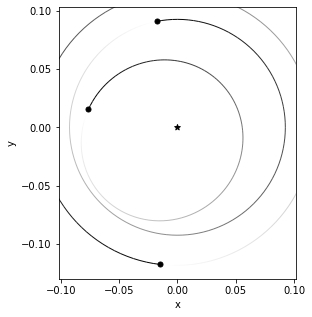

In [30]:
%matplotlib inline
row = crossing_stable.iloc[0]
sa = rebound.SimulationArchive('K23uniform/K23_logm_sa_{0}.bin'.format(int(row['sim'])))
sim = sa[0]
fig = rebound.OrbitPlot(sim)

Of the 97 non-crossing configurations in the prior, about 60% don't live $10^4$ orbits and can be removed perfectly by SPOCK

In [31]:
prior_noncrossing = prior[prior['crossing']==False]
prior_noncrossing.shape[0]

152

In [32]:
prior_noncrossing[prior_noncrossing['spockprob'] == 0].shape[0]/prior_noncrossing.shape[0]

0.6381578947368421

We have 9414 samples out of the 2M that don't cross orbits and survive $10^4$ orbits, of which 825 are stable

In [33]:
sample1e4 = df[(df['spockprob']>0)&(df['crossing']==False)]
sample1e4.shape[0]

9414

In [34]:
sample1e4[sample1e4['nbodystable']==1].shape

(825, 22)

In [35]:
825/9414

0.08763543658381134

# Nbody Integrations

We ran the N-body integrations for the paper manually, so above we just read the instability times from the SimulationArchives we ran.

However, SPOCK makes it easier to make one-to-one comparisons between the classifier and Nbody integrations (by choosing the same timestep, collision criteria etc.). By default, `NbodyRegressor.predict_instability_time` integrates over 1e9 inner planet orbits (the length of time over which SPOCK is trained to make predictions). We also pass it the same filename of the SimulationArchive (again, this will overwrite the original file, which is fine). Finally we explicitly pass it the interval we want between snapshots (so that we end up with 1000 snapshots if the simulation is stable). Definitely see 

https://github.com/dtamayo/spock/blob/master/jupyter_examples/ComparingToNbody.ipynb

for more details before doing long integrations. 

In [36]:
def init_regressor():
    global nbodyreg
    nbodyreg = NbodyRegressor()

def nbody(ID):
    safilename = 'K23uniform/K23_logm_sa_{0}.bin'.format(int(ID))
    sa = rebound.SimulationArchive(safilename)
    sim = sa[0]
    P1_init = sim.particles[1].P
    t_inst = nbodyreg.predict_instability_time(sim, archive_filename=safilename, archive_interval=1e6*P1_init)
    
    # nbody returns t_inst in simulation units--convert to inner planet orbits
    return t_inst/P1_init 

In [37]:
pool = Pool(processes=48, initializer=init_regressor)

# This cell would take a long time to run!

In [ ]:
%%time
simIDs = df['sim'].values
df['t_instability'] = pool.map(nbody, simIDs)